<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>


<h1 style="text-align: center;">Evaluating Cosine Similarity</h1>


**What is Cosine Similarity?**: Cosine similarity measures the similarity between two vectors of an inner product space. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction. It is often used to measure document similarity in text analysis.

**How is it useful in evaluating Large Language Models?**: It can be used to evaluate the quality of a language model by comparing the cosine similarity between the embeddings of two sentences. If the cosine similarity is high, then the language model is able to capture the semantic similarity between the two sentences. If the cosine similarity is low, then the language model is not able to capture the semantic similarity between the two sentences. 

#### Create an API Key

To get started, you will first need to get your API key from the [Uptrain Website](https://uptrain.ai/dashboard).

1. Login with Google
2. Click on "Create API Key"
3. Copy the API key and save it somewhere safe


#### Install the Uptrain Python Package

In [ ]:
!pip install uptrain

#### Step 1: Create an API Client

In [3]:
from uptrain import APIClient, Settings

settings = Settings(
    uptrain_access_token=YOUR_API_KEY,
    uptrain_server_url="https://demo.uptrain.ai"
)

client = APIClient(settings)

#### Step 2: Add dataset
Unlike the previous method where you had to create a dataset in Python, this method requires you to upload a file containing your dataset. The supported file formats are:

- .csv
- .json
- .jsonl

You can add the dataset file to the UpTrain platform using the `add_dataset` method.

To upload your dataset file, you will need to specify the following parameters:
- `name`: The name of your dataset
- `fpath`: The path to your dataset file

Let's say you have a dataset file called `qna-notebook-data.jsonl` in your current directory. You can upload it using the code below.

In [18]:
import os

url = "https://uptrain-assets.s3.ap-south-1.amazonaws.com/data/qna-streamlit-docs.jsonl"
dataset_path = os.path.join(os.getcwd(), "qna-notebook-data.jsonl")

if not os.path.exists(dataset_path):
    import httpx

    r = httpx.get(url)
    with open(dataset_path, "wb") as f:
        f.write(r.content)

client.add_dataset(name="qna-dataset", fpath=dataset_path)

{'name': 'qna-dataset', 'version': 4}

#### Step 3: Add checksets
A checkset contains the operators you wish to evaluate your model on. You can learn more about checksets [here](/key-components/checkset).

You can add a checkset using the `add_checkset` method.

To add a checkset, you will need to specify the following parameters:
- `name`: The name of your checkset
- `checkset`: The checkset you wish to add
- `settings`: The settings you defined while creating the API client

In [ ]:
from uptrain.framework import Check, CheckSet
from uptrain.operators import CosineSimilarity, JsonReader, Histogram, RougeScore

rouge_score = RougeScore(
    score_type="precision",
    col_in_generated="response",
    col_in_source="document_text",
    col_out="hallucination-score",
)

cosine_similarity = CosineSimilarity(
    col_in_vector_1="question_embeddings",
    col_in_vector_2="context_embeddings",
    col_out="similarity-question-context",
)

list_checks = [
    Check(
        name="hallucination_check",
        operators=[rouge_score],
        plots=[
            Histogram(props=dict(x="hallucination-score", nbins=20)),
        ],
    ),
    Check(
        name="similarity_check",
        operators=[cosine_similarity],
        plots=[
            Histogram(
                props=dict(x="similarity-question-context", nbins=20)
            ),
        ],
    ),
]

check_set = CheckSet(
    source=JsonReader(fpath=dataset_path),
    checks=list_checks
)

client.add_checkset(
    name="qna-checkset",
    checkset=check_set,
    settings=settings
)

#### Step 4: Add run
A run is a combination of a dataset and a checkset. You can learn more about runs [here](/key-components/run).

You can add a run using the `add_run` method.

To add a run, you will need to specify the following parameters:
- `dataset`: The name of the dataset you wish to add
- `checkset`: The name of the checkset you wish to add

In [20]:
response = client.add_run(
    dataset="qna-dataset",
    checkset="qna-checkset"
)

#### Step 5: View the results
You can view the results of your evaluation by using the `get_run` method.

In [25]:
client.get_run(response["run_id"])

{'run_id': '3532199a8887459386f53f806f740239',
 'created_at': '2024-01-10T11:25:45.595074',
 'updated_at': '2024-01-10T11:25:51.640624',
 'status': 'completed',
 'result': '',
 'dataset': 'qna-dataset',
 'checkset': 'qna-checkset',
 'dataset_version': 4,
 'checkset_version': 3}


You can also view the results on the [UpTrain Dashboard](https://demo.uptrain.ai/dashboard/) by entering your API key as a password.

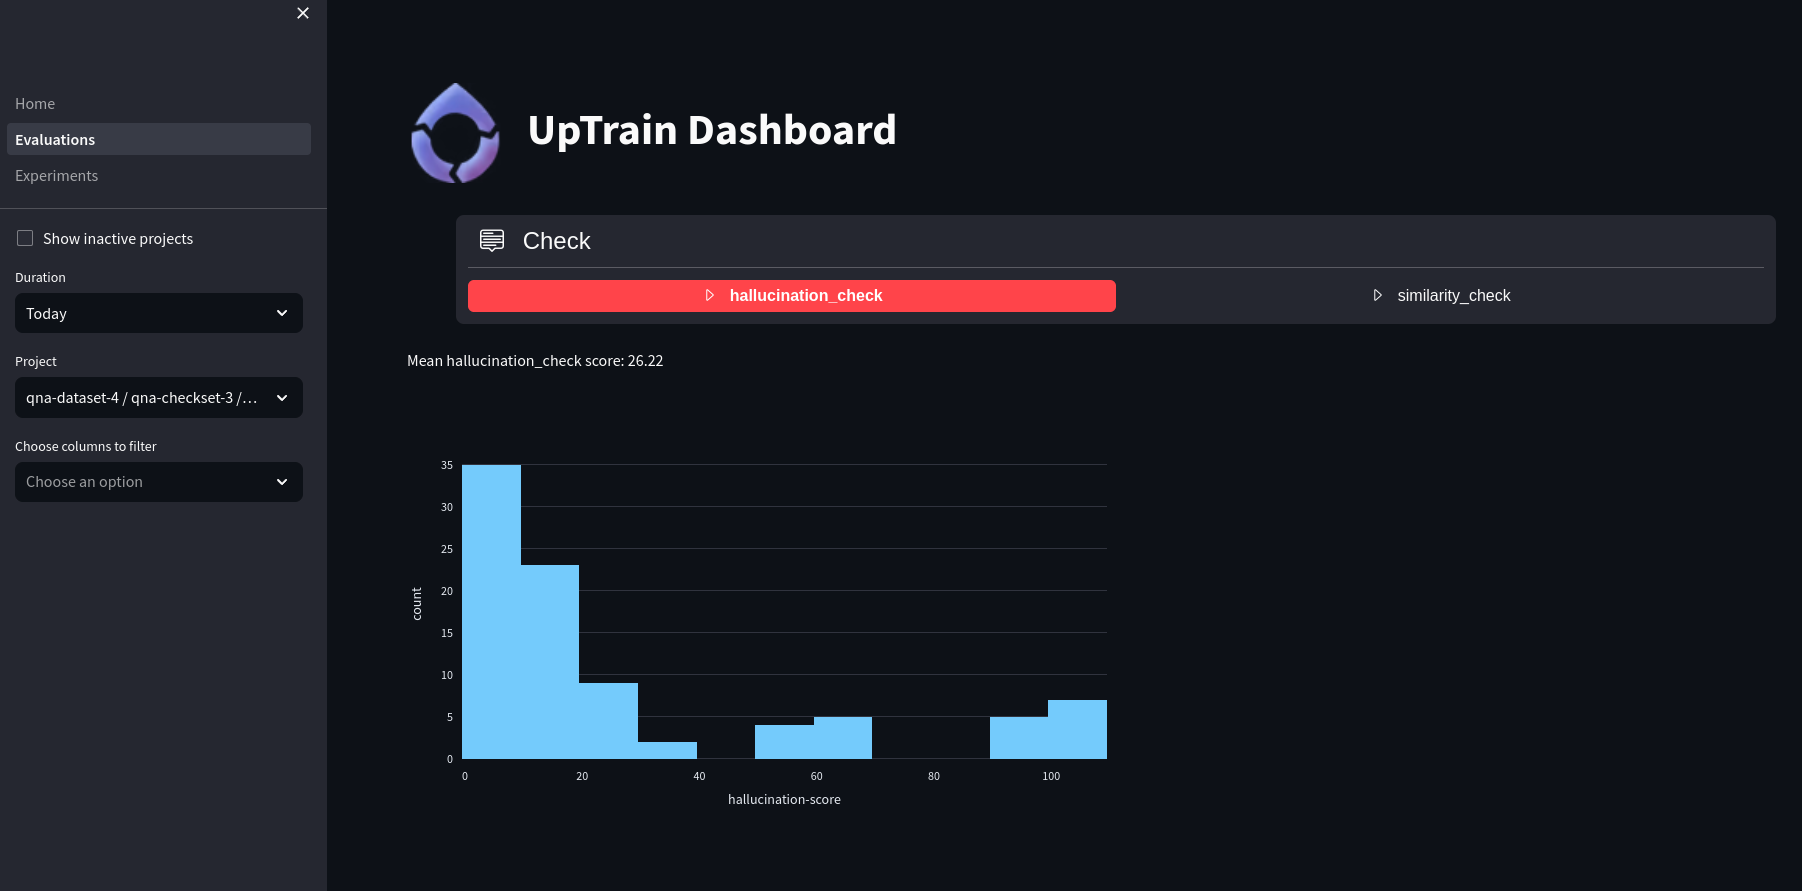